__Load and pre-process dataset__


In [85]:
import pickle

# read in saved data
fil = open('oics_2017.pckl', 'rb') #file containing the saved oics dictionary that holds the data
oics=pickle.load(fil)
fil.close()


Assemble the "precis" texts into a list:

In [86]:
texts = []

for n,d in zip(range(1,1749),oics): # there are 1748 entries, 'precis_2017-nnnn' is the key to each
    if 'precis_2017-'+str(n).zfill(4) in d: #10 OICs are not present in the set so only read if the number exists
        texts.append(d['precis_2017-'+str(n).zfill(4)])
        
#pick a few random examples
indices = [10,109,1104]
for i in indices:
    print "\nIndex", i, ":"
    print texts[i]


Index 10 :
Appointment of the HONOURABLE PETER W.L. MARTIN as a member of the Independent Judicial Advisory Committee for the Province of Alberta to hold office during pleasure for a term expiring March 1, 2019.

Index 109 :
HECATE STRAIT AND QUEEN CHARLOTTE SOUND GLASS SPONGE REEFS MARINE PROTECTED AREAS REGULATIONS in order to conserve and protect the biological diversity, structural habitat and ecosystem function of the glass sponge reefs.

Index 1104 :
CERTIFICATE OF SUPPLEMENTARY PROTECTION REGULATIONS in order to establish the Certificates of Supplementary Protection regime which implements Canada's commitment in the Canada-European Union Comprehensive Economic and Trade Agreement by providing for an additional period of patent-like protection for drugs containing a new medicinal ingredient, or a new combination of medicinal ingredients.


Basic stats on the OICs:

In [87]:
oic_lengths = [len(s.split()) for s in texts] #number of tokens (proxy for words) in each OIC precis
import numpy as np

print "Description of OIC texts:"
print "Mean: ", np.array(oic_lengths).mean()
print "Minimum: ", min(oic_lengths)
print "Maximum: ", max(oic_lengths)


Description of OIC texts:
Mean:  37.8808975834
Minimum:  1
Maximum:  302


__Feature Extraction__

Get some data about the words contained in the orders

      occurrences         term  frequency
527           851  appointment   0.022429
3527          843       office   0.022218
2328          764         hold   0.020136
935           749       canada   0.019741
3566          732        order   0.019293
4756          701         term   0.018476
121           681         2017   0.017948
3211          549       member   0.014469
5174          533        years   0.014048
3549          470      ontario   0.012387
1717          468    effective   0.012335
3768          419     pleasure   0.011043
794           358        board   0.009435
4078          336  regulations   0.008856
4810          330         time   0.008697
1337          326        court   0.008592
2142          311         good   0.008197
3273          309     minister   0.008144
717           308    behaviour   0.008118
2644          262        judge   0.006905


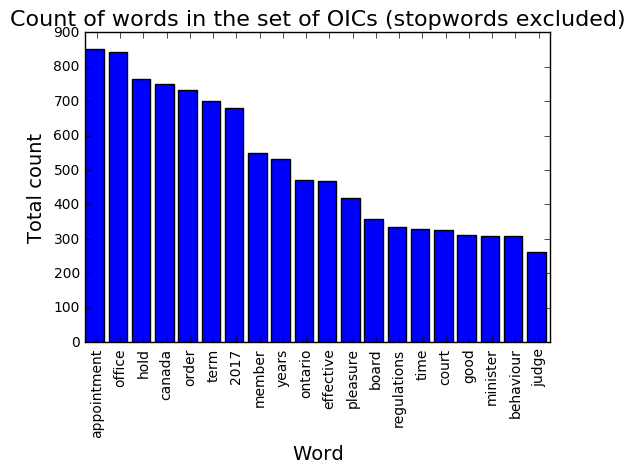

In [88]:
from sklearn.feature_extraction.text import CountVectorizer #use an unweighted word count
import operator

import pandas as pd
import matplotlib.pyplot as plt

vectorizer = CountVectorizer(stop_words='english') #set up word counter
X_raw = vectorizer.fit_transform(texts)# get the word counts

# Build a dataframe containing the word counts
# code based on https://stackoverflow.com/questions/23842540/how-is-term-frequency-calculated-in-scikit-learn-countvectorizer
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(X_raw.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])

# find the top 20 words
df_sorted = word_freq_df.sort_values(by='occurrences',ascending = False)[:20]

print df_sorted

#plot as a bar chart
fig, ax = plt.subplots()
plt.bar(range(0,20),df_sorted['occurrences'],tick_label=df_sorted['term'])
plt.xticks(np.array(range(0,20))+.5, df_sorted['term'], rotation='vertical')

plt.xlabel("Word", fontsize=14)
plt.ylabel("Total count", fontsize=14)
plt.title("Count of words in the set of OICs (stopwords excluded)", fontsize=16);
plt.show()





Extract features weighted by inverse document frequency, using tf-idf vectorizer

      occurrences         term  frequency
3527    77.707614       office   0.011252
527     76.421664  appointment   0.011066
2328    71.439662         hold   0.010345
121     69.242327         2017   0.010027
4756    69.234743         term   0.010026
935     63.795908       canada   0.009238
5174    60.792790        years   0.008803
3211    60.600175       member   0.008775
3549    59.477139      ontario   0.008613
1717    55.006393    effective   0.007965
3566    54.313677        order   0.007865
1337    51.531035        court   0.007462
3768    51.393162     pleasure   0.007442
794     46.995909        board   0.006805
2644    44.340283        judge   0.006421
2142    44.163773         good   0.006395
4810    44.133364         time   0.006391
717     43.900813    behaviour   0.006357
3916    38.345814     province   0.005553
3954    38.014081       quebec   0.005505


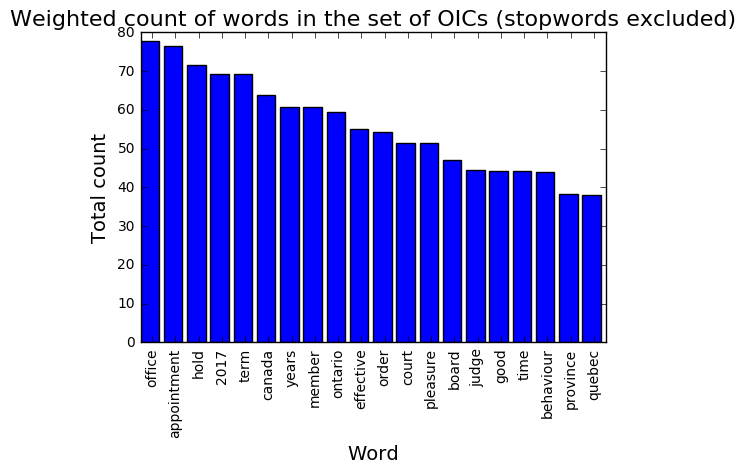

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english') #overwrite vectorizer with tf-idf
X = vectorizer.fit_transform(texts)

# get word counts (weighted)
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])

# extract the top 20
df_sorted = word_freq_df.sort_values(by='occurrences',ascending = False)[:20]

print df_sorted

# plot
fig, ax = plt.subplots()
plt.bar(range(0,20),df_sorted['occurrences'],tick_label=df_sorted['term'])
plt.xticks(np.array(range(0,20))+.5, df_sorted['term'], rotation='vertical')

plt.xlabel("Word", fontsize=14)
plt.ylabel("Total count", fontsize=14)
plt.title("Weighted count of words in the set of OICs (stopwords excluded)", fontsize=16);
plt.show()



To get the proportion about appointments (for the report), count the number that contain the string appointment

In [91]:
app_count = 0
dc = 0
for t in texts:
    if 'Appointment' in t or 'appointment' in t:
        app_count = app_count+1
print app_count

        

1052


Get the shape of x to see how many features:

In [92]:
X

<1738x5202 sparse matrix of type '<type 'numpy.float64'>'
	with 34046 stored elements in Compressed Sparse Row format>

__Clustering__

Calculate the silhouette score for different numbers of clusters to determine and apprporiate number to word with

2 : 0.0204047852316
3 : 0.0285091958951
4 : 0.0241817133626
5 : 0.0284499000877
6 : 0.0316618820703
7 : 0.033183364006
8 : 0.0360737793484
9 : 0.0371231458835
10 : 0.0380781438828
11 : 0.0381115584084
12 : 0.0403170890018
13 : 0.0429167073587
14 : 0.0417182652021
15 : 0.0431414024679
16 : 0.0415473935448
17 : 0.045487609136
18 : 0.0436524669638
19 : 0.0459013354943


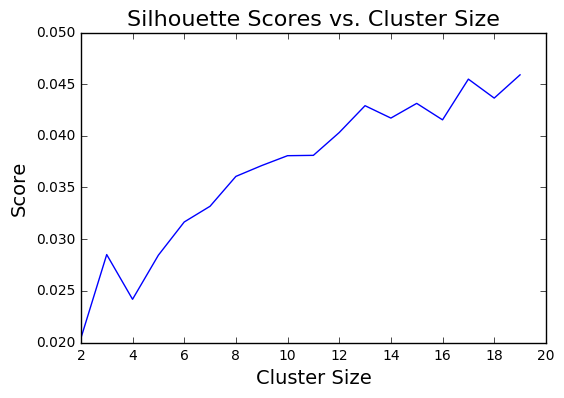

In [93]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


scores = []
for clusters in range (2,20): #we are looking from 2-19 clusters
    av = []
    for v in range (10): #ten runs each, to average and variations in random state
    
        km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1,verbose=False) #initialize

        km.fit(X) #fit and predict the labels
        preds = km.predict(X)
        av.append(silhouette_score(X,preds)) # get the silhouette score
    ssc = np.array(av).mean() #take the average score for ten runs at each number of clusters
    print clusters, ':', ssc
    scores.append(ssc)

# plot the overall result
plt.plot(range(2,20), scores)
plt.xlabel("Cluster Size", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Silhouette Scores vs. Cluster Size", fontsize=16);
plt.show()
    
    



Cluster using an appropriate number

In [94]:
clusters = 10 #chosen number

#use the same random state every time for repeatability 
km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1,verbose=True,random_state=1)

km.fit(X)

Initialization complete
Iteration  0, inertia 2861.474
Iteration  1, inertia 1540.028
Iteration  2, inertia 1517.080
Iteration  3, inertia 1502.681
Iteration  4, inertia 1492.791
Iteration  5, inertia 1490.714
Iteration  6, inertia 1490.170
Iteration  7, inertia 1489.775
Iteration  8, inertia 1488.980
Iteration  9, inertia 1488.116
Iteration 10, inertia 1488.031
Iteration 11, inertia 1487.960
Iteration 12, inertia 1487.955
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.851796e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=True)

Display the keywords associated with each cluster

In [99]:
# term extraction based on code from the example at http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py
order_centroids = km.cluster_centers_.argsort()[:, ::-1] #get the indices for top terms (highest weights) for each cluster centre
terms = vectorizer.get_feature_names()

dff = pd.DataFrame(columns=["Cluster " +str(n) for n in range(clusters)]) #build a blank data frame

for i in range(clusters):
    dff["Cluster " +str(i)]=np.array([terms[ind] for ind in order_centroids[i, :10]]) #add the top 10 terms for each cluster

dff
    


Cluster 0    Cluster 1        Cluster 2    Cluster 3 Cluster 4  Cluster 5  \
0   tribunal       office           consul    directors     court     period   
1       good         hold         honorary     director     judge     parole   
2  behaviour         term           period        board  superior   division   
3       time     pleasure         republic     pleasure   justice   regional   
4     member  appointment           canada         term  province  corporate   
5   security        years            years        years       hon     canada   
6       term      ontario       ambassador     approval    appeal      board   
7       2017       member  plenipotentiary         hold   annuity       time   
8       hold    effective    reappointment       office  granting  behaviour   
9     office       ottawa    extraordinary  appointment   ontario       plan   

       Cluster 6    Cluster 7    Cluster 8    Cluster 9  
0      inclusive        order     expiring      refugee  
1  administrator  regulations  independent  immigration  
2            hon       canada         2019       office  
3          serve          act     judicial     regional  
4     government     minister     advisory        board  
5           2017    agreement    committee         time  
6    appointment  authorizing     province    behaviour  
7        october     amending     pleasure         good  
8       columbia         2017       member       member  
9        british   government         term      toronto

Look at a subset of OICs contained in each cluster to get a better sense of them. These are also provided in the appendix

In [96]:
# initialize a data structure to store the OIC texts by cluster
clustered = {}

for r in range(clusters):
    clustered[r]=[]

# move each OIC into a cluster based on label
for l,t in zip(km.labels_,texts):
    clustered[l].append(t)

np.random.seed(1) #we want to look at the same random subset for consistency
for k in clustered: # display ten from each category
    print "Cluster ", k
    inds = np.random.randint(0,len(clustered[k]),10)
    for c in inds:
        print clustered[k][c], "\n"

Cluster  0
Reappointment of VIRGINIA LEE SAUNDERS of Vancouver, British Columbia, as a full-time member of the Social Security Tribunal for the Income Security Section, to hold office during good behaviour for a term of three years, effective October 1, 2017. 

Reappointment of GAÉTAN MÉNARD of Lochaber Ouest, Quebec, as a full-time member of the Canada Industrial Relations Board, to hold office during good behaviour for a term of three years. 

Appointment of JAIME LYNNE MELLOTT of Pender Island, British Columbia, as a full-time member of the Social Security Tribunal for the Income Security Section, to hold office during good behaviour for a term of three years, effective July 6, 2017. 

Appointment of GARY WILLIAM CONRAD of Sherwood Park, Alberta, to be a full-time member of the Social Security Tribunal for the Employment Insurance Section, to hold office during good behaviour for a term ending May 28, 2020, effective December 18, 2017. 

Appointment of the Honourable KONRAD WINRICH 

__Visualization__

Use the TSNE module to reduce the feature space to 2D for plotting

In [97]:
from sklearn.decomposition import TruncatedSVD # docs recommend first using SVD to reduce the feature space to ~50
svd = TruncatedSVD(50,random_state=2) #initialize Truncated SVD and reduce dimensionality from 5202 to 50
xx = svd.fit_transform(X)
print(svd.explained_variance_ratio_.sum()) #just curious


from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(xx) #use TSNE to transform to 2 dimensions
print X_embedded.shape

0.324023746109
(1738, 2)


Plot the TNSE embedded data, coloring each point according to its cluster, determined earlier

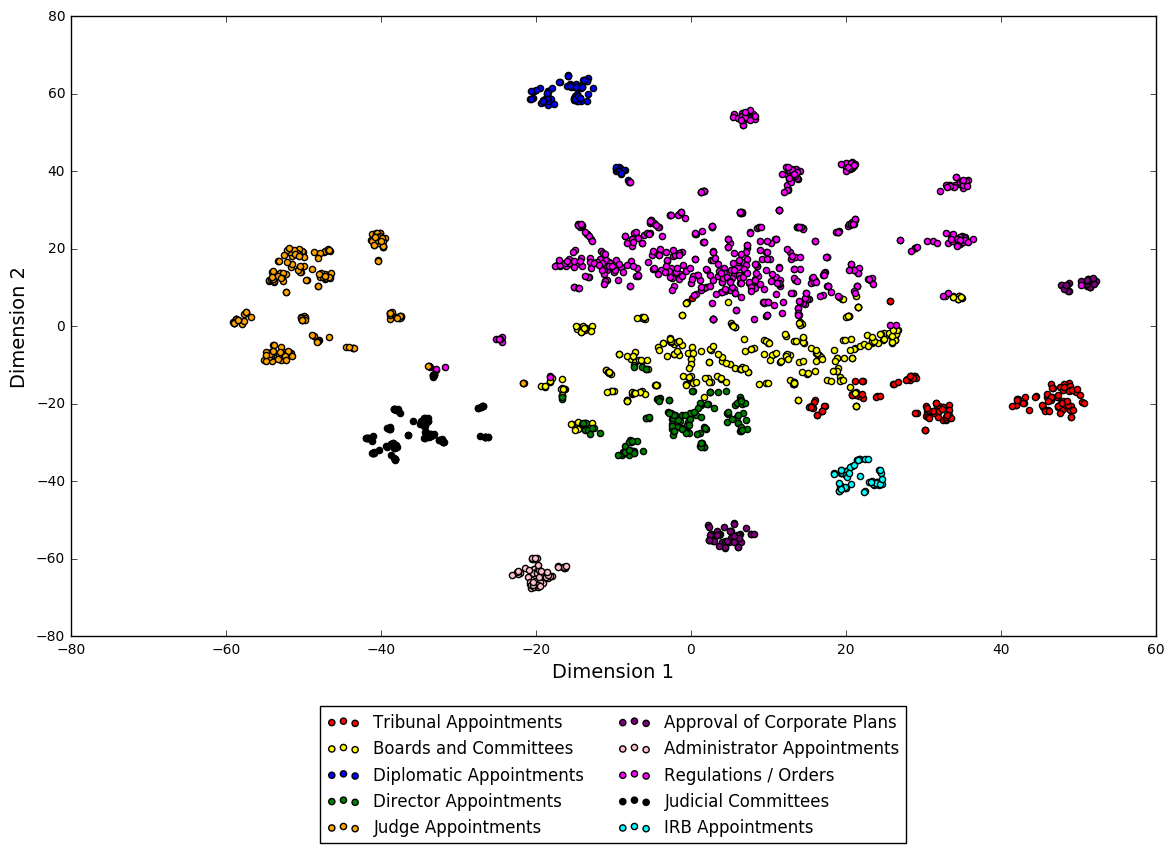

In [98]:
import itertools
clustered_points = {}

for r in range(clusters):
    clustered_points[r]=[]

for l,t in zip(km.labels_,X_embedded): #assign embedded points to labels based on the kmeans clustering
    clustered_points[l].append(t)

plt.subplots(figsize = (14,8))

#colors for plotting
cols =itertools.cycle(['red', 'yellow', 'blue', 'green', 'orange', 'purple', 'pink', 'magenta', 'black', 'cyan'])

#labels, determined based on subset of extracted OICs earlier
labels = ['Tribunal Appointments', 'Boards and Committees', 'Diplomatic Appointments', 'Director Appointments', 'Judge Appointments', 'Approval of Corporate Plans', 'Administrator Appointments', 'Regulations / Orders', 'Judicial Committees', 'IRB Appointments']

#plot each cluster separately, giving it a different color
for f in clustered_points:
    plt.scatter(np.array(clustered_points[f])[:,0],np.array(clustered_points[f])[:,1],c=next(cols),label=labels[f])
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)
plt.show()


__Enhancements__

Do the same thing with bigrams

In [41]:
#repeat of earlier feature extraction code, using ngram_range=(1,2) to get word pairs as well as single words
vectorizer2 = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
X2 = vectorizer2.fit_transform(texts)

word_freq_df = pd.DataFrame({'term': vectorizer2.get_feature_names(), 'occurrences':np.asarray(X2.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])

df_sorted = word_freq_df.sort_values(by='occurrences',ascending = False)[:20]

print df_sorted
X2

       occurrences             term  frequency
13102    48.535902           office   0.004841
2174     47.876435      appointment   0.004776
8959     44.618856      hold office   0.004451
8958     44.617418             hold   0.004450
18064    43.319549             term   0.004321
480      42.924387             2017   0.004282
3903     40.563470           canada   0.004046
19362    38.023904            years   0.003793
11973    38.023243           member   0.003793
13200    37.345555          ontario   0.003725
13301    35.127426            order   0.003504
6925     34.051631        effective   0.003397
18081    33.055967       term years   0.003297
5652     32.909601            court   0.003283
14146    32.211036         pleasure   0.003213
13115    32.194132  office pleasure   0.003211
3462     29.232234            board   0.002916
14152    29.063481    pleasure term   0.002899
10218    28.305913            judge   0.002823
18238    27.472629             time   0.002740


<1738x19446 sparse matrix of type '<type 'numpy.float64'>'
	with 69068 stored elements in Compressed Sparse Row format>

Re-run the silhoutte scoring for different numbers of clusters

2 : 0.013483121964
3 : 0.0175380337477
4 : 0.0195214438477
5 : 0.0225391215476
6 : 0.0241676871955
7 : 0.0250559428871
8 : 0.0274657342125
9 : 0.0281060682295
10 : 0.0297499007024
11 : 0.0303571723187
12 : 0.0313772812736
13 : 0.0325757775548
14 : 0.0313585911863
15 : 0.0331022819722
16 : 0.0348141447102
17 : 0.0358140339129
18 : 0.0368319407024
19 : 0.0379087437945


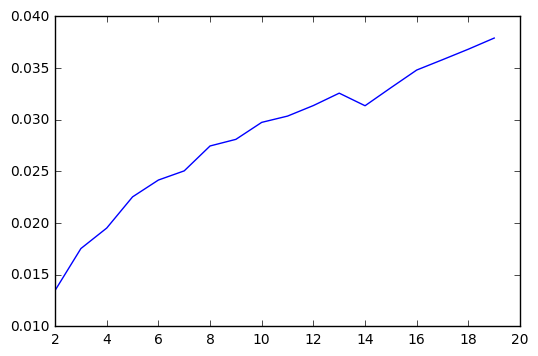

In [233]:
# as in earlier code block, run k-means 10 times for each number of clusters and calculate and plot the average silhouette score
scores = []
for clusters in range (2,20):
    av = []
    for v in range (10):
    # standard k-means, no dimensionality reduction
        km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1,verbose=False)

        km.fit(X2)
        preds = km.predict(X2)
        av.append(silhouette_score(X2,preds))
    ssc = np.array(av).mean()
    print clusters, ':', ssc
    scores.append(ssc)

plt.plot(range(2,20), scores)
plt.show()

Proceed with clustering with an appropriate number of clusters

In [36]:
clusters = 10

km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1,verbose=True,random_state=1)

km.fit(X2)

Initialization complete
Iteration  0, inertia 3038.386
Iteration  1, inertia 1594.713
Iteration  2, inertia 1572.443
Iteration  3, inertia 1568.025
Iteration  4, inertia 1566.388
Iteration  5, inertia 1565.228
Iteration  6, inertia 1564.909
Iteration  7, inertia 1564.107
Iteration  8, inertia 1563.056
Iteration  9, inertia 1562.721
Iteration 10, inertia 1562.577
Iteration 11, inertia 1562.514
Converged at iteration 11: center shift 0.000000e+00 within tolerance 5.032556e-09


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=True)

Get the most highly weighted features (words or word pairs) in each cluster

In [39]:
# same code as in previous case
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer2.get_feature_names()

dff = pd.DataFrame(columns=["Cluster " +str(n) for n in range(clusters)])

for i in range(clusters):
    dff["Cluster " +str(i)]=np.array([terms[ind] for ind in order_centroids[i, :10]])

dff
    

Cluster 0        Cluster 1             Cluster 2       Cluster 3  \
0           security  office pleasure           regulations  behaviour term   
1  security tribunal         pleasure                 order     office good   
2      member social           office              amending            good   
3    social security    pleasure term  regulations amending  good behaviour   
4             social      hold office     regulations order       behaviour   
5           tribunal             hold                   act          office   
6       section hold             term              commerce     time member   
7            section       term years              schedule            time   
8        time member            years               chambre            term   
9        office good      appointment                canada          member   

          Cluster 4        Cluster 5             Cluster 6  \
0          columbia     period years         term expiring   
1  british columbia           period  independent judicial   
2           british         honorary     judicial advisory   
3     court british  honorary consul              expiring   
4     judge supreme    consul canada    member independent   
5           supreme           consul    advisory committee   
6     supreme court           canada           independent   
7             judge     board canada              judicial   
8             court            years                  2019   
9         vancouver           parole              advisory   

                  Cluster 7       Cluster 8             Cluster 9  
0                       hon           court                 order  
1                 inclusive           judge                canada  
2            2017 inclusive    court appeal              minister  
3                      2017  superior court                  2017  
4                   annuity        superior           authorizing  
5          granting annuity          appeal             agreement  
6                  granting         justice     order authorizing  
7  administrator government  judge superior                   act  
8       serve administrator              ex            government  
9             administrator      ex officio  authorizing minister

Display a random subset of each cluster (these are provided in the appendix)

In [40]:
# repeat of code to randomly choose 10 indices and display the corresponding OICs for each cluster
clustered = {}

for r in range(clusters):
    clustered[r]=[]

for l,t in zip(km.labels_,texts):
    clustered[l].append(t)

np.random.seed(1)
for k in clustered:
    print "Cluster ", k
    inds = np.random.randint(0,len(clustered[k]),10)
    for c in inds:
        print clustered[k][c], "\n"

Cluster  0
Reappointment of CHARLINE BOURQUE of Québec, Quebec, as a full-time member of the Social Security Tribunal for the Employment Insurance Section, to hold office during good behaviour for a term of three years, effective May 11, 2017. 

Reappointment of TAKIS PAPPAS of Pickering, Ontario, as a full-time member of the Social Security Tribunal for the Employment Insurance Section, to hold office during good behaviour, effective March 16, 2017, for a term ending on September 30, 2017. 

Reappointment of BRIAN RAY RODENHURST of Woodstock, Ontario, as a full-time member of the Social Security Tribunal for the Income Security Section, to hold office during good behaviour, effective March 16, 2017, for a term ending on September 30, 2017. 

Reappointment of VIRGINIA LEE SAUNDERS, of Vancouver, British Columbia, as a full-time member of the Social Security Tribunal for the Income Security Section, to hold office during good behaviour, effective March 23, 2017, for a term ending on Sep

__Validation__

Read in a separate set of data and classify using the determined clusters

In [51]:
# read in the set of OICs from 2016
import pickle

# read in saved data
fil = open('oics_2016.pckl', 'rb')
oics=pickle.load(fil)
fil.close()


In [64]:
# assemble the text from each into a list
texts2 = []

for n,d in zip(range(1,100),oics):
    if 'precis_2016-'+str(n).zfill(4) in d:
        texts2.append(d['precis_2016-'+str(n).zfill(4)])


Extract features (using the vectorizer fit to the eariler data set (single words only)

In [65]:
print vectorizer #print just to validate we are working with the originally trained vectorizer
vectorizer.fit(texts) #fit on the original set of texts
X3 = vectorizer.transform(texts2) #transform the newly read in set of texts into feature space

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


Clustering - fit with original data (2017 set) and then predict the labels for the 2016 data points

In [74]:
clusters = 10

km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1,verbose=True,random_state=1)

km.fit(X) #fit to 2017 data
c_labels = km.predict(X3) #predict on 2016 data

Initialization complete
Iteration  0, inertia 2861.474
Iteration  1, inertia 1540.028
Iteration  2, inertia 1517.080
Iteration  3, inertia 1502.681
Iteration  4, inertia 1492.791
Iteration  5, inertia 1490.714
Iteration  6, inertia 1490.170
Iteration  7, inertia 1489.775
Iteration  8, inertia 1488.980
Iteration  9, inertia 1488.116
Iteration 10, inertia 1488.031
Iteration 11, inertia 1487.960
Iteration 12, inertia 1487.955
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.851796e-08


Bucket the OIC texts into clusters

In [76]:
print c_labels.shape
clustered_test = {}

for r in range(clusters):
    clustered_test[r]=[]

for l,t in zip(c_labels,texts2):
    clustered_test[l].append(t)

(99,)


Display the entire set for review. This is included in the appendix

In [81]:
for r in range(clusters):
    print labels[r]
    for k in clustered_test[r]:
        print k, '\n'

Tribunal Appointments
Appointment of PIERRE DESJARDINS of Longueuil, Quebec, to be a temporary member of the Veterans Review and Appeal Board, to hold office during good behaviour for a term of one year, effective March 14, 2016. 

Reappointment of JOHN A. CLARKSON of Ottawa, Ontario, as a full-time member of the Canadian Transportation Accident Investigation and Safety Board, to hold office during good behaviour for a term of six months, effective February 27, 2016. 

Boards and Committees
Appointment of MARC-ANDRÉ BLANCHARD of Toronto, Ontario, as Ambassador and Permanent Representative of Canada to the United Nations, in New York, to hold office during pleasure, effective April 1, 2016. 

Appointment of HUGUETTE LABELLE, C.C., O.Ont., of Ottawa, Ontario, as a special adviser to the Prime Minister, to serve as the Chairperson of the Independent Advisory Board for Senate Appointments, to hold office during pleasure for a term of 30 months. 

Appointment of INDIRA V. SAMARASEKERA, O.C.